# Entity Matching for Online Marketplaces



## What is Entity Matching (EM)?

## Why is EM needed for online marketplaces?

## Exploratory Data Analysis

### Dataset Origin

### Offer Features

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import pickle

from IPython.display import display, HTML

import warnings
# warnings.filterwarnings('ignore')

# load custom functions
os.chdir('C:/Users/kyleg/Entity-Matching-in-Online-Retail')
# os.chdir('H:/kgilde/Entity-Matching-in-Online-Retail')
exec(open("utility_functions.py").read())

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [24]:
# Load Data
ORIGINAL_DIRECTORY = os.getcwd()
DATA_DIRECTORY = 'D:/Documents/Large-Scale Product Matching/'
os.chdir(DATA_DIRECTORY)

train_test_feature_pairs = pd.read_csv('train_test_feature_pairs.csv')
train_test_offer_features = pd.read_csv('train_test_offer_features.csv')
train_test_normalized_features = pd.read_csv('train_test_normalized_features.csv')

attribute_comp_features_9 = pd.read_csv('attribute_comparison_features-9.csv')

var_imp_coef = pd.read_csv('logreg-variable-coefficients-importance.csv').set_index('Feature')

C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# PLOT_DIRECTORY = '//files/share/goods/OI Team/plots'
PLOT_DIRECTORY = 'plots'
SHORT_TEXT_FEATURES = ['gtin', 'mpn', 'sku', 'identifier', 'brand', 'manufacturer']
PRODUCT_IDENTIFIERS = ['gtin', 'mpn', 'sku', 'identifier']
BRAND_MANUFACTURER =  ['brand', 'manufacturer']
MEDIUM_LONG_TEXT_FEATURES = ['name', 'description']
OTHER_FEATURES = ['price']
ALL_FEATURES = SHORT_TEXT_FEATURES + MEDIUM_LONG_TEXT_FEATURES + OTHER_FEATURES
  
test_ids = train_test_feature_pairs[(train_test_feature_pairs.label == 1) &
                                    (train_test_feature_pairs.dataset == 'test')]\
                [['offer_id_1', 'offer_id_2']]\
                .stack()\
                .unique()
    
train_test_offer_features_only = train_test_offer_features[ALL_FEATURES]
test_offer_features_only = train_test_offer_features.loc[train_test_offer_features.offer_id.isin(test_ids), ALL_FEATURES]

os.chdir(ORIGINAL_DIRECTORY)
os.chdir(PLOT_DIRECTORY)

### Top Domains

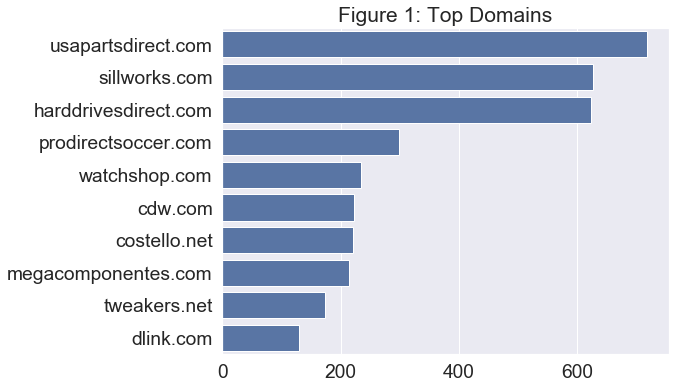

In [4]:
domains = train_test_offer_features.domain.str.replace('www\.|de\.', '')\
    .value_counts().head(10)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.75)

sns.barplot(x=domains.values, y=domains.index, 
            color="b")\
            .set_title('Figure 1: Top Domains')

plt.savefig('fig-01-top-domains.png', bbox_inches = "tight")


### Sparsity

In [5]:
null_percentages = calculate_percent_nulls(train_test_offer_features_only, print_series=False, return_series=True)
nulls_by_index = train_test_offer_features[null_percentages.index].isnull().T

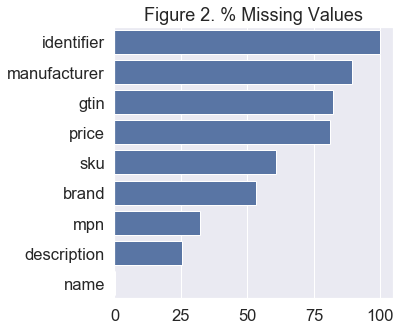

In [6]:
plt.figure(figsize=(5, 5))
sns.set(font_scale=1.5)

sns.barplot(x=null_percentages.values, 
            y=null_percentages.index, 
            color="b")\
            .set_title('Figure 2. % Missing Values')

plt.savefig("fig-02-feature-sparsity.png", bbox_inches = "tight")

In [7]:
msno.heatmap

<function missingno.missingno.heatmap(df, inline=False, filter=None, n=0, p=0, sort=None, figsize=(20, 12), fontsize=16, labels=True, cmap='RdBu')>

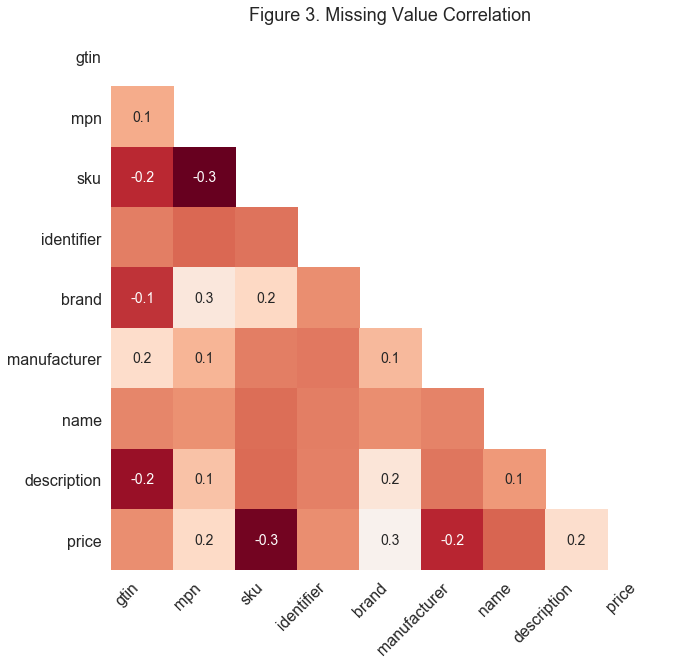

In [8]:
msno.heatmap(train_test_offer_features_only, figsize=(10, 10)).set_title("Figure 3. Missing Value Correlation")

plt.savefig("fig-03-missing-value-correlation.png", bbox_inches = "tight")

## Features

### Short Text Character Lengths

In [9]:
# count chararters for short-text features
# identifiers_features = train_test_normalized_features[PRODUCT_IDENTIFIERS]
# char_counts_identifiers_features = identifiers_features.apply(lambda s: s.str.len(), axis=1)
short_text_features = train_test_normalized_features[SHORT_TEXT_FEATURES]
char_counts_df = short_text_features.apply(lambda s: s.str.len(), axis=1)

In [10]:
char_counts_df.median()

gtin            12.0
mpn              9.0
sku              9.0
identifier       9.0
brand           13.0
manufacturer     7.0
dtype: float64

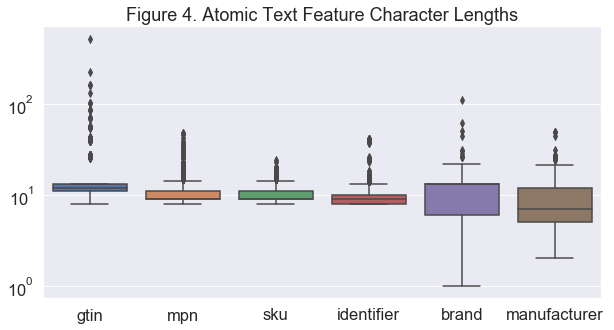

In [11]:
plt.figure(figsize=(10, 5))
sns.set(font_scale=1.5)

ax = sns.boxplot(data = char_counts_df)
ax.set_title('Figure 4. Atomic Text Feature Character Lengths')

ax.set(yscale='log')

# plt.figure(figsize=(10, 5))
# sns.set(font_scale=1.5)

# ax = sns.boxplot(data = char_counts_identifiers_features)
# ax.set_title('Figure 4. Product Identifier Character Lengths')
# ax.xaxis.tick_top()
# ax.set(yscale='log')

plt.savefig("fig-04-character-lengths.png", bbox_inches = "tight")

### Top Brands & Manufacturers

In [12]:
top_values =\
    train_test_normalized_features[['brand', 'manufacturer']]\
        .melt()\
        .dropna().groupby(['variable', 'value'])['value'].agg('count')\
        .to_frame()\
        .rename(index=str, columns={'value': 'value_counts'})\
        .reset_index()\
        .groupby(['variable'])\
        .apply(lambda x: x.nlargest(10, 'value_counts'))\
        .reset_index(drop=True)

top_values['value'] = top_values.value.str.slice(stop=25)

C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 3600x1800 with 0 Axes>

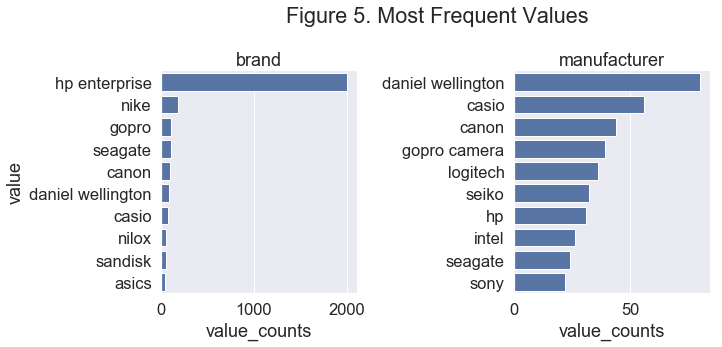

In [13]:
plt.figure(figsize=(50, 25))
g = sns.FacetGrid(top_values, col="variable", col_wrap=5, sharey=False, sharex=False)
g.fig.set_figwidth(25)
g.fig.set_figheight(5)
g.map(sns.barplot, 'value_counts', 'value')
g.set_titles("{col_name}") 
plt.subplots_adjust(top=.8)
g.fig.suptitle('Figure 5. Most Frequent Values', x=.25)
                    
plt.savefig("fig-05-brand-manufacturer-top-values.png", bbox_inches = "tight")
# https://stackoverflow.com/a/48208266/4463701

In [14]:
overlap = train_test_normalized_features[['brand', 'manufacturer']].dropna().apply(lambda x: x[0] == x[1], 1).value_counts()
overlap / overlap.sum()

True     0.779359
False    0.220641
dtype: float64

In [15]:
# count words
medium_long_features = train_test_normalized_features[MEDIUM_LONG_TEXT_FEATURES]
word_counts_df = medium_long_features.apply(count_words, axis=1)

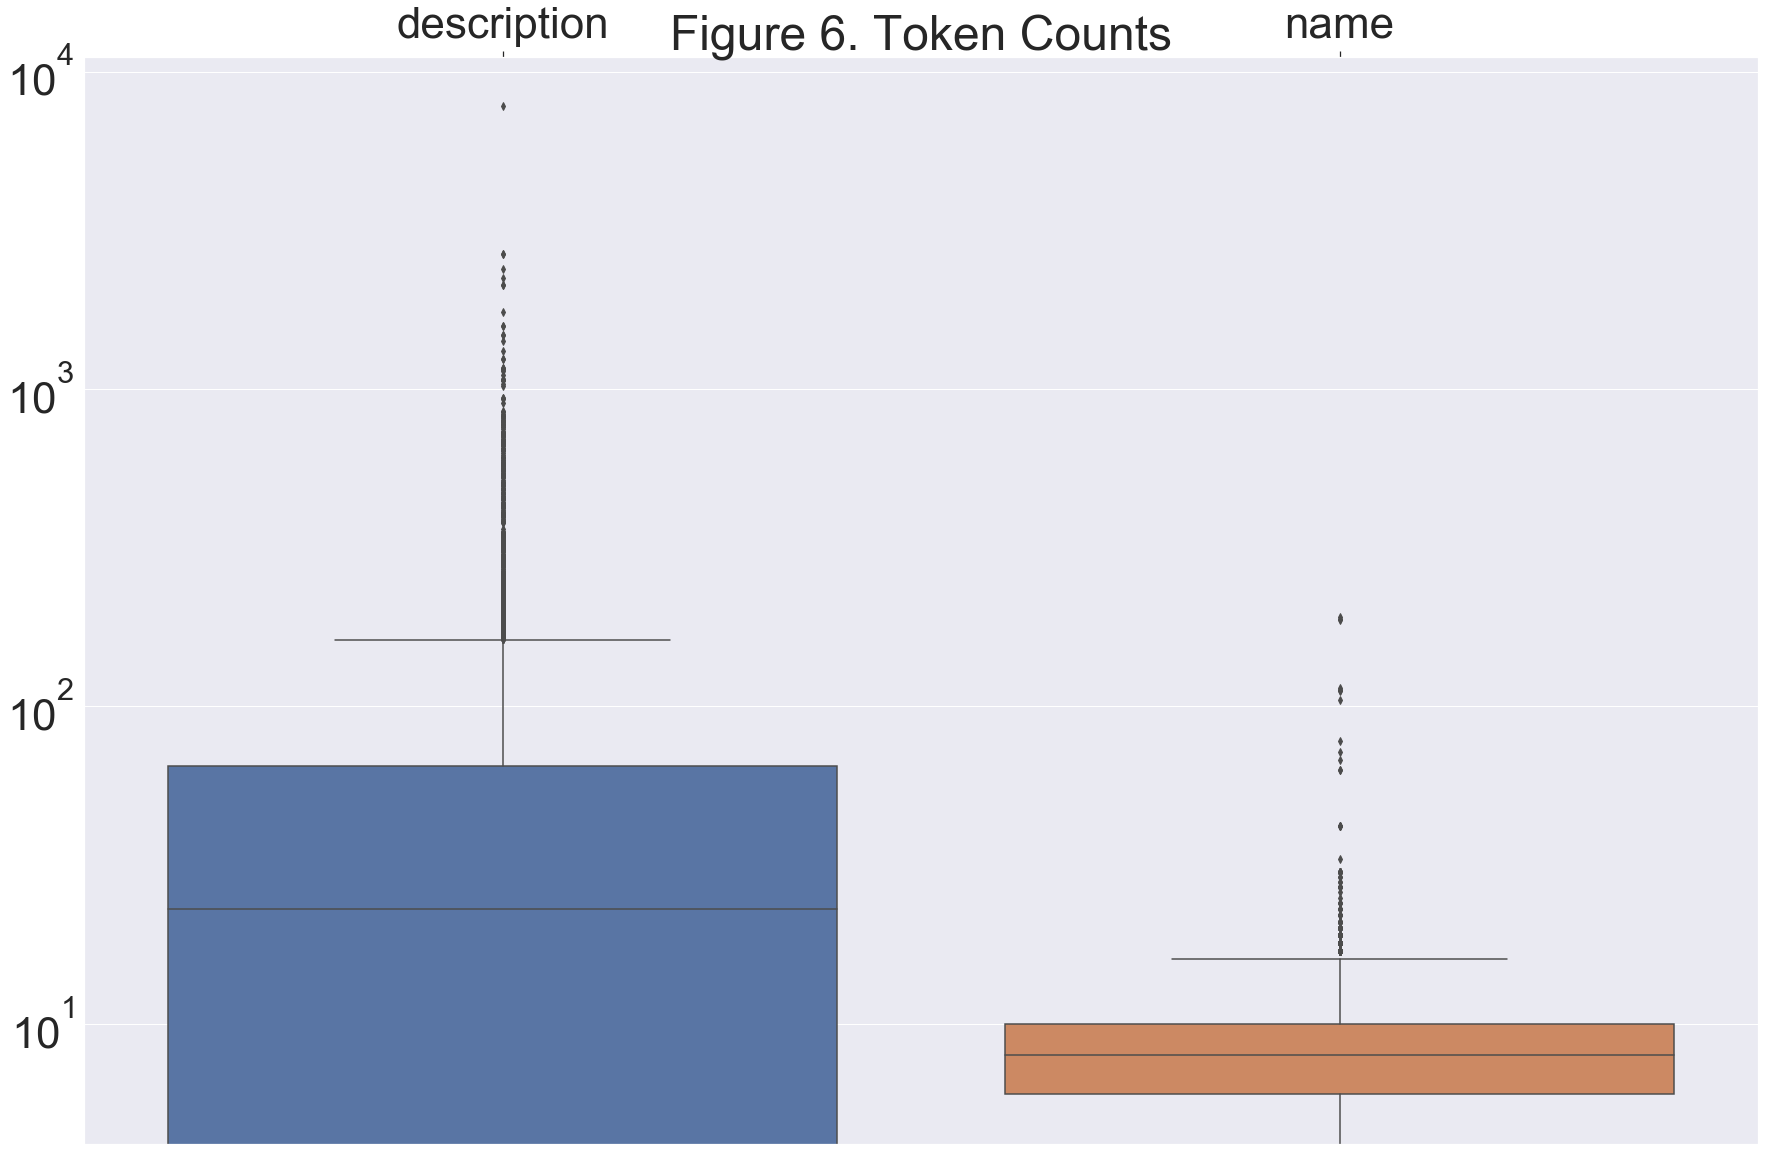

In [16]:
plt.figure(figsize=(30, 20))
sns.set(font_scale=4)

ax = sns.boxplot(data = word_counts_df)
ax.set_title('Figure 6. Token Counts')
ax.xaxis.tick_top()
ax.set(yscale='log')

plt.savefig("fig-06-name-descrition-word-counts.png", bbox_inches = "tight")

In [17]:
word_counts_df.median()

description    23.0
name            8.0
dtype: float64

### Training & Testing Data

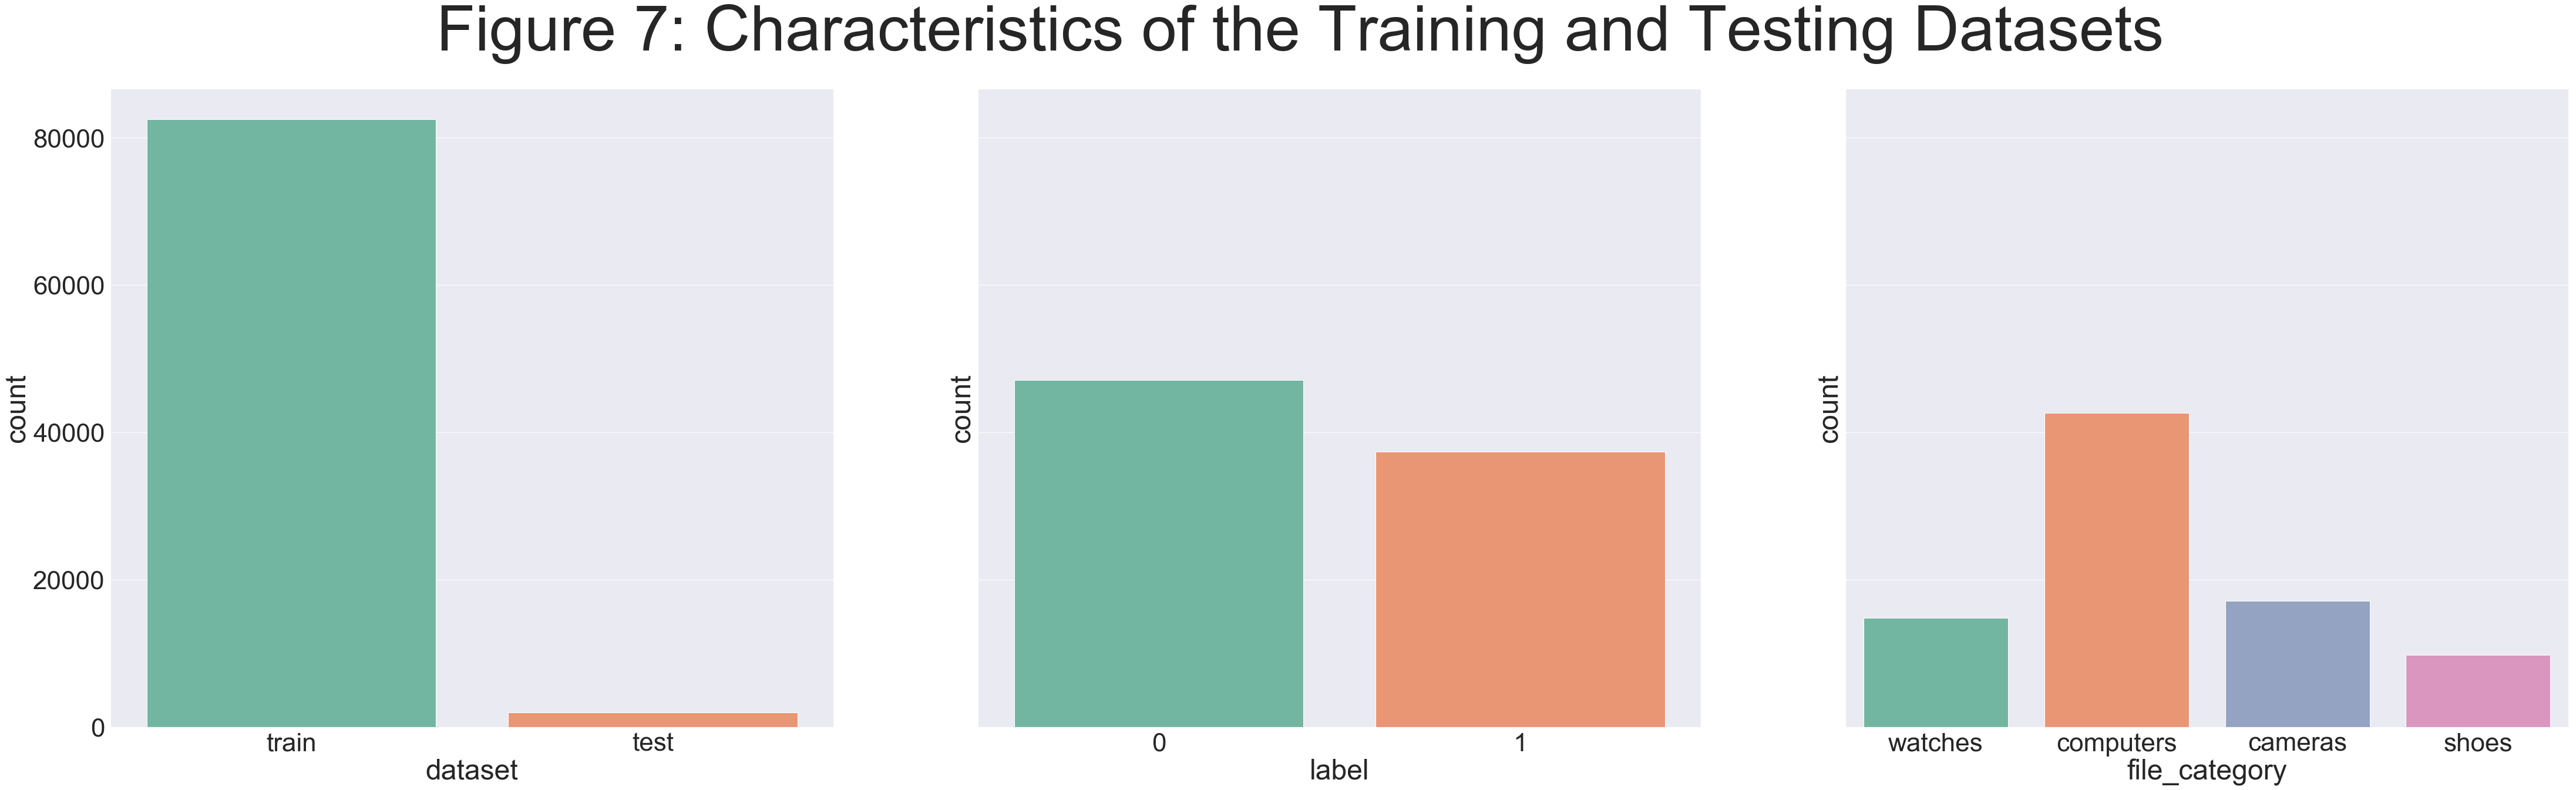

In [18]:
test_train_characteristics = train_test_feature_pairs[['label', 'dataset', 'file_category']]


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(75, 20), sharey=True) 

sns.set(font_scale=5.5)
plt.rcParams.update({'font.size': 90})
st = fig.suptitle("Figure 7: Characteristics of the Training and Testing Datasets")

sns.countplot(x='dataset', data=test_train_characteristics, palette=sns.color_palette("Set2"), ax=axes[0])

sns.countplot(x='label', data=test_train_characteristics, palette=sns.color_palette("Set2"), ax=axes[1])

sns.countplot(x='file_category', data=test_train_characteristics, palette=sns.color_palette("Set2"), ax=axes[2])

plt.savefig('fig-07-test-train-characteristics.png', bbox_inches = "tight")

### Testing Data

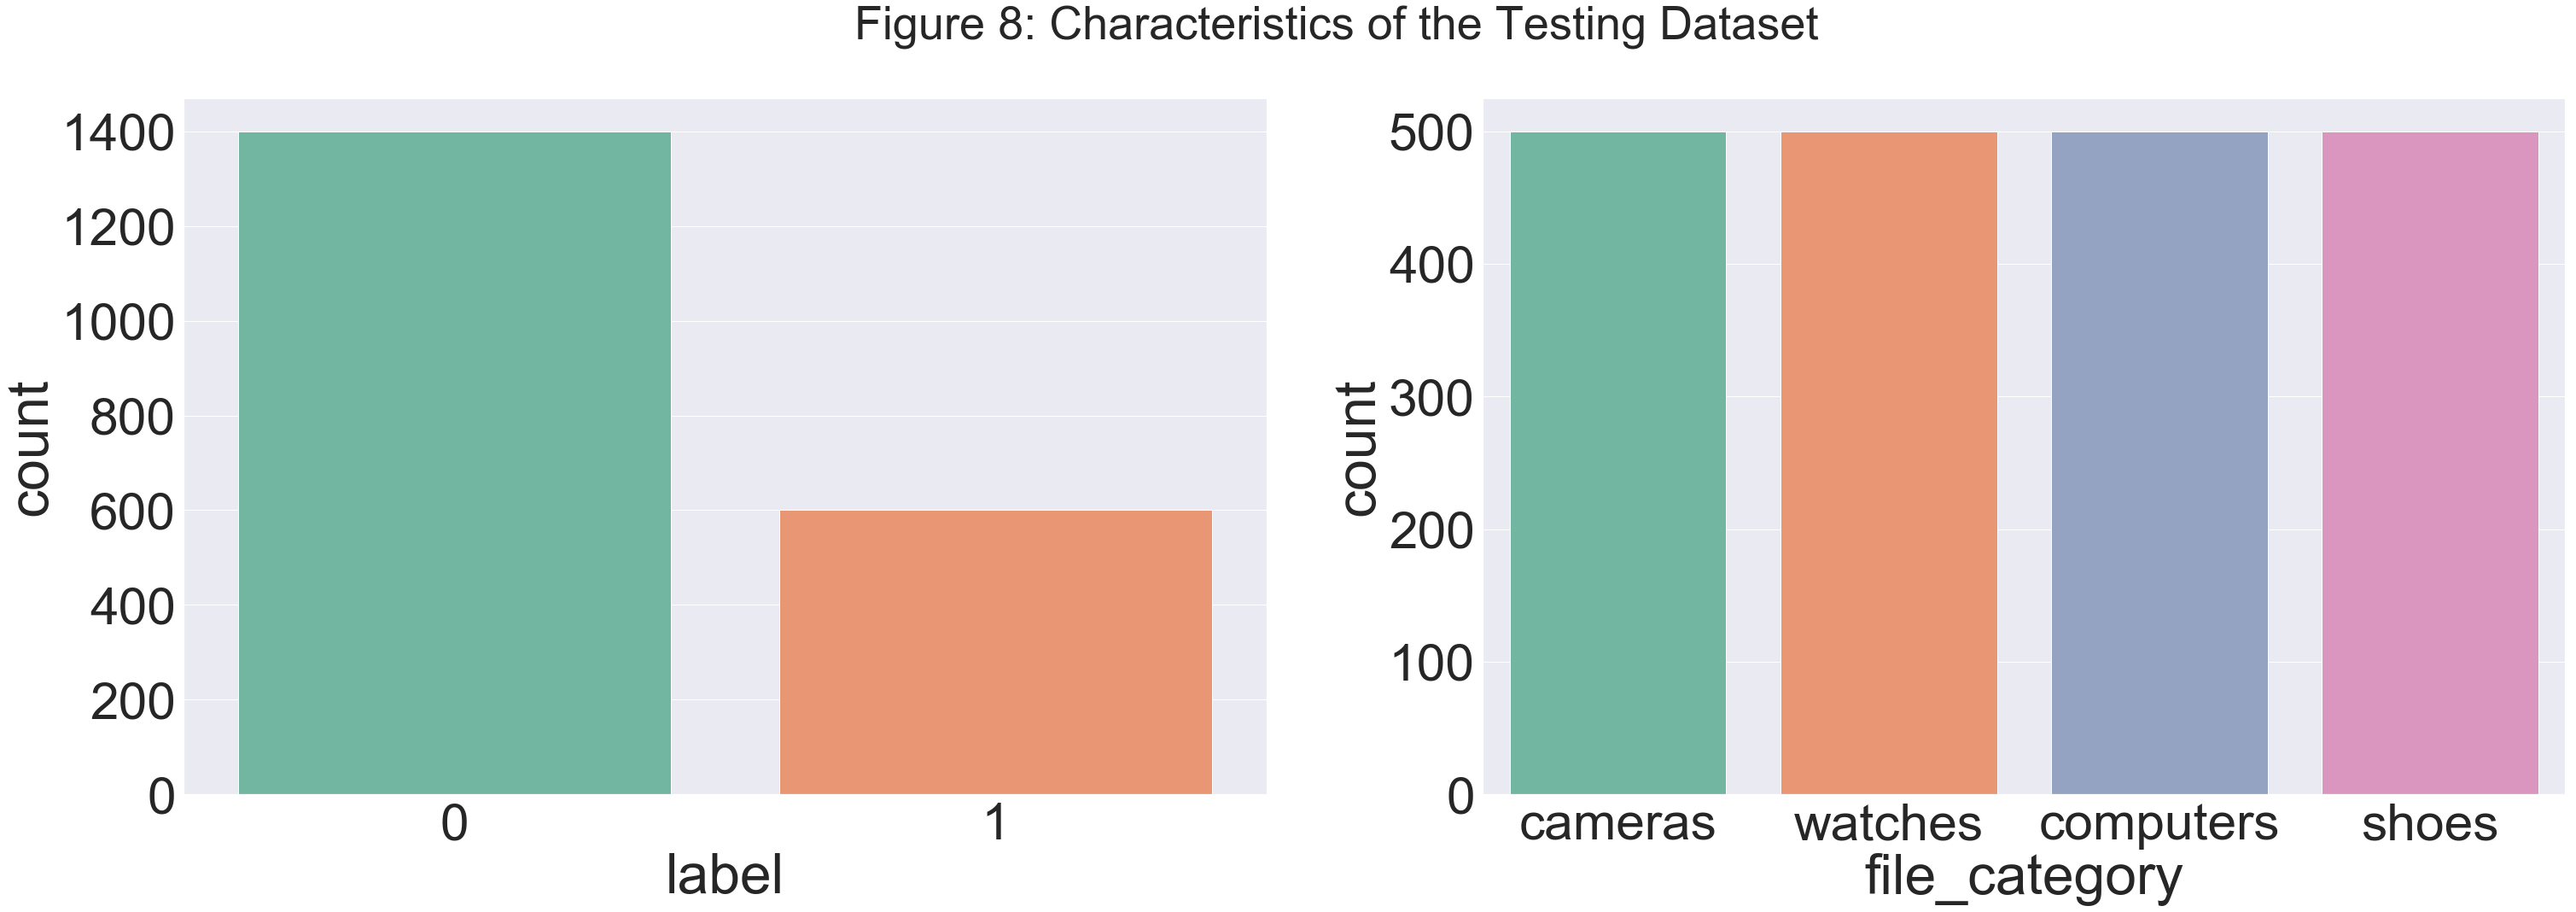

In [19]:
test_characteristics = test_train_characteristics[test_train_characteristics.dataset == 'test']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(50, 15)) #

sns.set(font_scale=4)
plt.rcParams.update({'font.size': 45})
st = fig.suptitle("Figure 8: Characteristics of the Testing Dataset")

sns.countplot(x='label', data=test_characteristics, palette=sns.color_palette("Set2"), ax=axes[0])

sns.countplot(x='file_category', data=test_characteristics, palette=sns.color_palette("Set2"), ax=axes[1])

plt.savefig('fig-08-test-set-characteristics.png')

In [20]:
test_matches = train_test_feature_pairs[(train_test_feature_pairs.label == 1) &
                                      (train_test_feature_pairs.dataset == 'test')][['file_category', 
                                                                                   'name_1', 
                                                                                   'name_2']]\
.sample(4, random_state=1)

pd.set_option('display.max_colwidth', 0)
h = HTML(test_matches.to_html(index=False))
display(h)

my_file = open('table_1_matched_offer_pairs.html', 'w')
my_file.write(h.data)
my_file.close()

file_category,name_1,name_2
shoes,nike sportswear air force 1 07 white,sneakers buty nike air force 1 07 low white 315122 111
computers,323146 b21 bl20p g2 1p xeon 3 06ghz,323146 b21 bl20p xeon 3 06ghz
watches,daniel wellington dapper sheffield rose gold,daniel wellington men s dapper 38mm sheffield rose watch
cameras,canon eos rebel t5i,canon eos rebel t5i 18 135mm is stm digital slr camera kit black


### Feature Analysis

In [25]:
feature_corr = attribute_comp_features_9.corr()

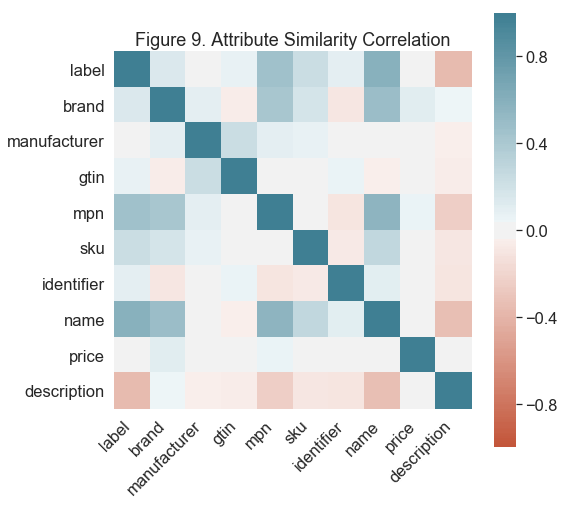

In [30]:
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.5)

ax = sns.heatmap(
    feature_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_title('Figure 9. Attribute Similarity Correlation')

settings =\
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
plt.savefig('fig-09-correlation.png', bbox_inches = "tight")
# source: https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec

In [21]:
var_imp = var_imp_coef.Overall.sort_values(ascending=False)
var_coef = var_imp_coef.Coefficient.sort_values(ascending=False)

<Figure size 576x1440 with 0 Axes>

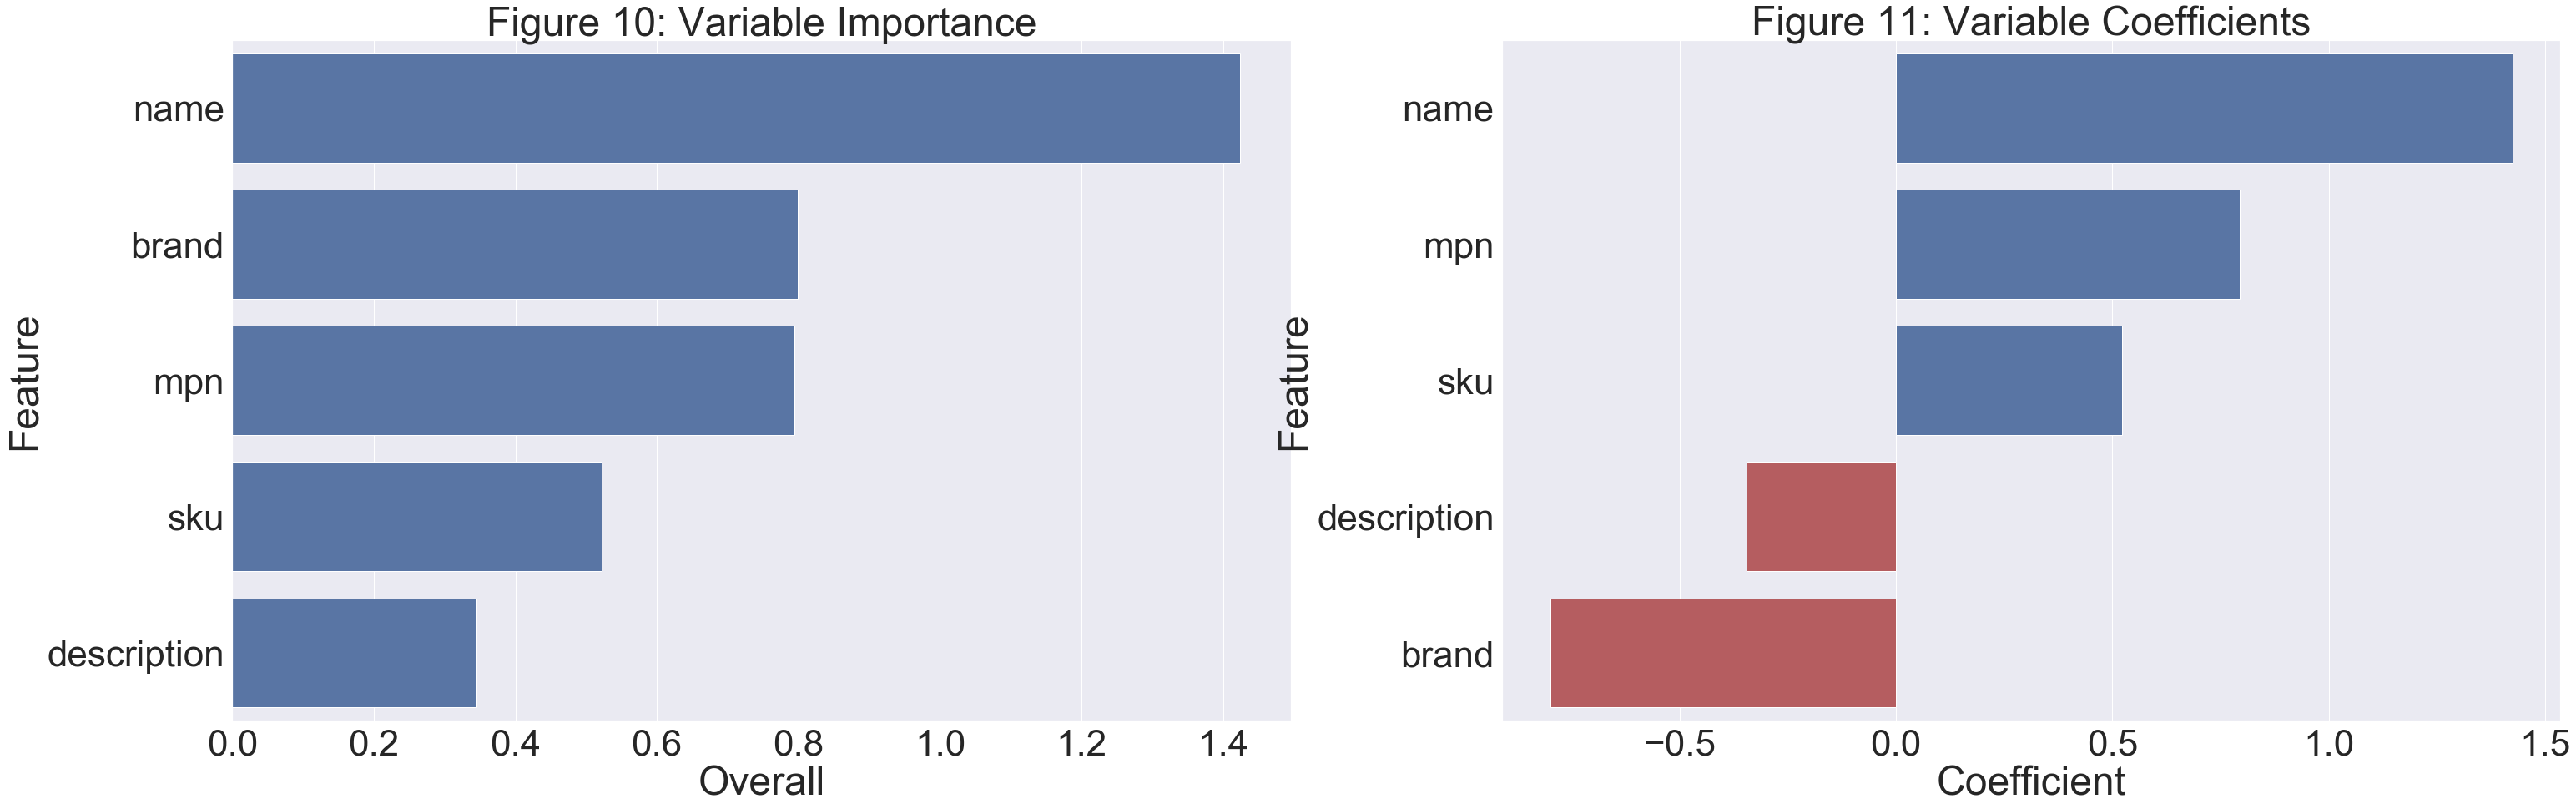

In [31]:
plt.figure(figsize=(8, 20))
sns.set(font_scale=4)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(50, 15))
sns.barplot(x=var_imp, 
            y=var_imp.index, 
            color="b", 
            ax=axes[0])\
            .set_title('Figure 10: Variable Importance')

sns.barplot(x=var_coef, 
            y=var_coef.index, 
            palette=var_coef.apply(lambda x: 'b' if x > 0 else 'r'),
            ax=axes[1])\
            .set_title('Figure 11: Variable Coefficients')


plt.savefig('fig-10-11-variable-importance-coefficients.png', bbox_inches = "tight")

### Variable Importance for Best Models

In [40]:
# get variable importance
os.chdir(DATA_DIRECTORY + '/attribute_comparison_features-9')

acf9_models = pickle.load(open('sklearn_models.pkl', 'rb'))

rf_acf9 = acf9_models[2].best_estimator_ 
input_feature_order = ['brand', 'manufacturer', 'gtin', 'mpn', 'sku', 'identifier', 'name', 'price', 'description']

var_imp_rf = pd.DataFrame({'feature': input_feature_order,
                           'importance': rf_acf9.feature_importances_})\
    .set_index('feature').sort_values('importance', ascending=False)

sgb_acf9 = acf9_models[3].best_estimator_ 
var_imp_sgb = pd.DataFrame({'feature': input_feature_order,
                           'importance': sgb_acf9.feature_importances_})\
    .set_index('feature').sort_values('importance', ascending=False)

os.chdir(ORIGINAL_DIRECTORY)
os.chdir(PLOT_DIRECTORY)

C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator GaussianNB from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator SVC from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator SVC from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid re

C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using ve

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'plots'

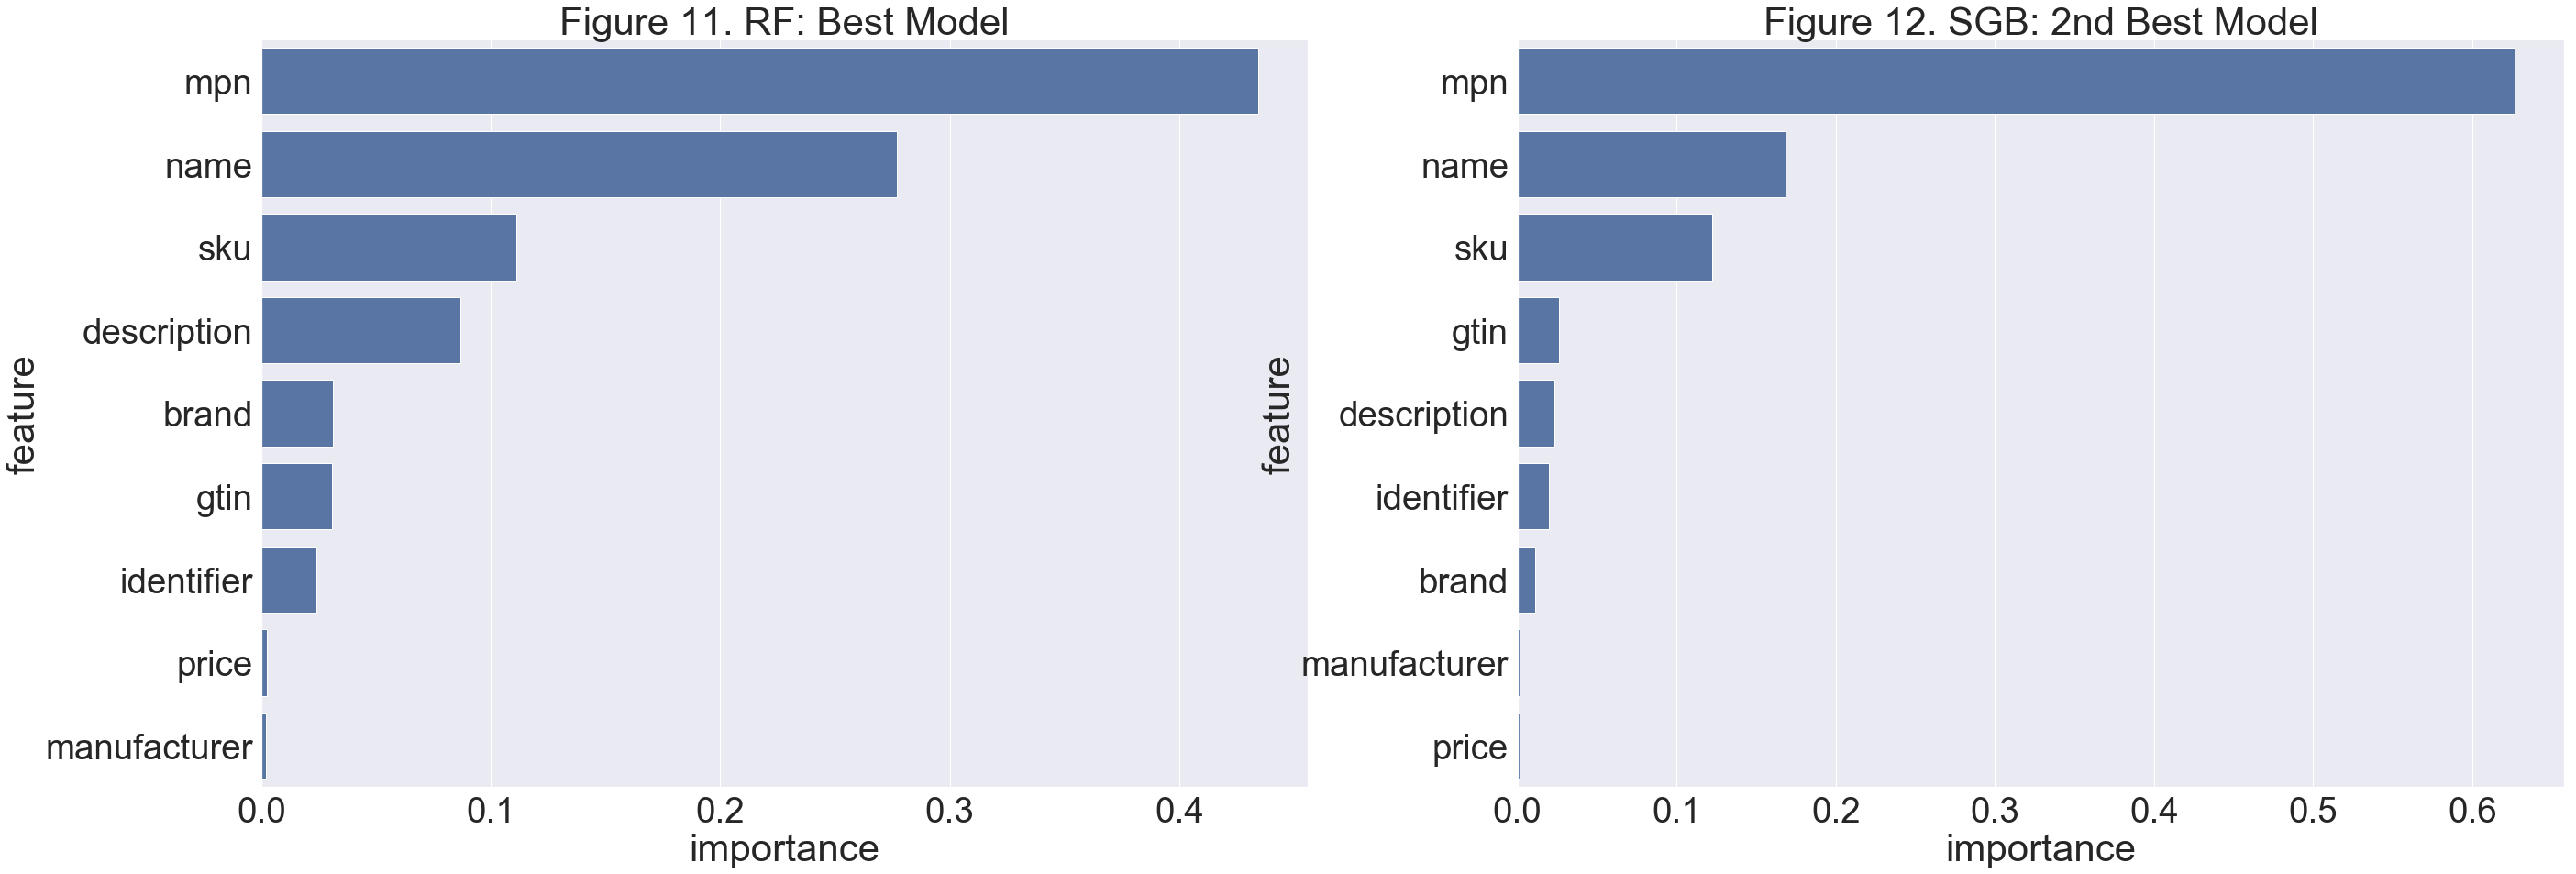

In [44]:
# plot variable importance
sns.set(font_scale=3.5)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(45, 15))

sns.barplot(x=var_imp_rf.importance,
           y=var_imp_rf.index,
           color='b',
           ax=axes[0])\
            .set_title('Figure 11. RF: Best Model')

sns.barplot(x=var_imp_sgb.importance,
           y=var_imp_sgb.index,
           color='b',
           ax=axes[1])

t2 = axes[1].set_title('Figure 12. SGB: 2nd Best Model')


plt.savefig('fig-11-12-variable-importance-coefficients.png', bbox_inches = "tight")

'C:\\Users\\kyleg\\Entity-Matching-in-Online-Retail\\plots'